# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
!pip install scipy==1.1.0

  Using cached scipy-1.1.0.tar.gz (15.6 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for scipy: filename=scipy-1.1.0-cp38-cp38-linux_x86_64.whl size=54472561 sha256=36b7a6bba8330223a20f2946d9f217ba94d4e660cd82463885ce8e94617da855
  Stored in directory: /home/.cache/pip/wheels/29/a9/5e/9e4eddde37a1e15cf5cb404ba197df482cc39ffbfef91ec337
Successfully built scipy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.2 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [93]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)


## Utility functions

### Plotting accuracy and loss

In [94]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras import optimizers
# from keras.layers import Dropout

#write your model here
# model = Sequential()
# model.add(Conv3D(32, (3, 3, 3), padding='same',
#          input_shape=(13,80,80,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5,activation='softmax'))

In [ ]:
# optimiser = 'sgd'
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [50]:
project_folder='/datasets/Project_data'

In [ ]:
import abc
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def train_model(self, model, augment_data=False):
            train_generator = generator(self.train_path, self.train_doc, self.batch_size)
            val_generator = generator(self.val_path, self.val_doc, self.batch_size)

            model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

            if not os.path.exists(model_name):
                os.mkdir(model_name)

            filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
            LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

            earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
            callbacks_list = [checkpoint, LR, earlystop]

            if (self.num_train_sequences%self.batch_size) == 0:
                steps_per_epoch = int(self.num_train_sequences/self.batch_size)
            else:
                steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

            if (self.num_val_sequences%self.batch_size) == 0:
                validation_steps = int(self.num_val_sequences/self.batch_size)
            else:
                validation_steps = (self.num_val_sequences//self.batch_size) + 1

#             history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
#                                 callbacks=callbacks_list, validation_data=val_generator, 
#                                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
            history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
            return history


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1: class definition


In [98]:

class Model1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(13,80,80,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [88]:
conv_model1_obj=Model1()
conv_model1_obj.initialize_path(project_folder)
conv_model1_obj.initialize_image_properties(image_height=160,image_width=160)
conv_model1_obj.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=5)
conv_model1_model=conv_3d1.define_model()
conv_model1_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_37 (Conv3D)          (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_37 (Activation)  (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_59 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 6, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_38 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_38 (Activation)  (None, 6, 40, 40, 64)   

In [95]:
print("Total Params:", conv_model1_model.count_params())

Total Params: 1733509


In [92]:

training_output_model1 = conv_model1_obj.train_model(conv_model1_model)

Source path =  /datasets/Project_data/train ; batch size = 40
Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.8650 - categorical_accuracy: 0.3294Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.58283, saving model to model_init_2025-01-2816_08_22.895165/model-00001-1.86500-0.32941-1.58283-0.23333.h5
17/17 [==============================] - 80s 5s/step - loss: 1.8650 - categorical_accuracy: 0.3294 - val_loss: 1.5828 - val_categorical_accuracy: 0.2333 - lr: 0.0100
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.2861 - categorical_accuracy: 0.5191
Epoch 00002: val_loss did not improve from 1.58283
17/17 [==============================] - 69s 4s/step - loss: 1.2861 - categorical_accuracy: 0.5191 - val_loss: 1.8728 - val_categorical_accuracy: 0.1750 - lr: 0.0100
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.0394 - categorical_accuracy: 0.5779
Epoch 00003: val_loss did no

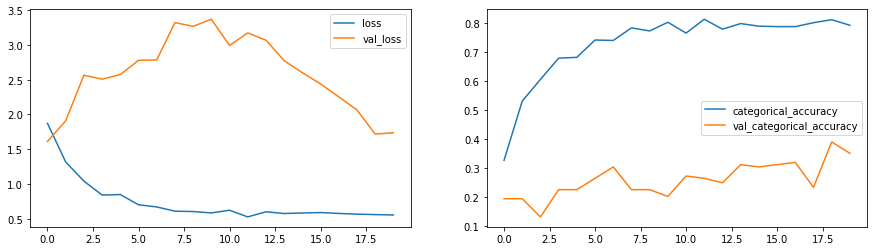

In [96]:
plot(history)